Regression Pipeline
===================

This script demonstrates how to preprocess data and run an Optuna study to tune hyperparameters 
for a regression model. The features are sourced from 'media-4.xlsx' (using the sheet 'all features')
while the target values (viability) are loaded from 'secretome_samples_for_RNAseq_170111.xlsx'.

The viability target is a continuous variable, so we modify the pipeline as follows:
  - Load the target from a new Excel file and select the columns ['Gene name', 'Viability (harvest) [%]'].
  - Rename columns so that the gene names match the feature dataframe index and rename the viability column to “Viability”.
  - Remove any sampling or stratification (since the target is continuous).
  - In the Optuna objective, choose among regression models and use an appropriate metric (R²).

In [1]:
#############################
# Import Libraries & Modules
#############################

import json
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Data splitting and imputation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score

# ML models
from xgboost import XGBRegressor
import shap
import optuna
from sklearn.linear_model import Ridge

In [2]:
###########################
# Define Helper Functions
###########################

def show_heatmap(df, predictor_list, target='Viability', figsize=(20, 10), title='Correlation Heatmap'):
    # Create a correlation matrix (only numeric columns) and plot a heatmap
    correlation_matrix = df[predictor_list + [target]].corr(method='pearson')
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
    plt.show()

def standardize_values(X):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

def t_sne_plot(X, y, title='t-SNE plot'):
    from sklearn.manifold import TSNE
    X_tsne = TSNE(n_components=2, random_state=0).fit_transform(X)
    plt.figure(figsize=(10,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.colorbar(label='Viability')
    plt.show()

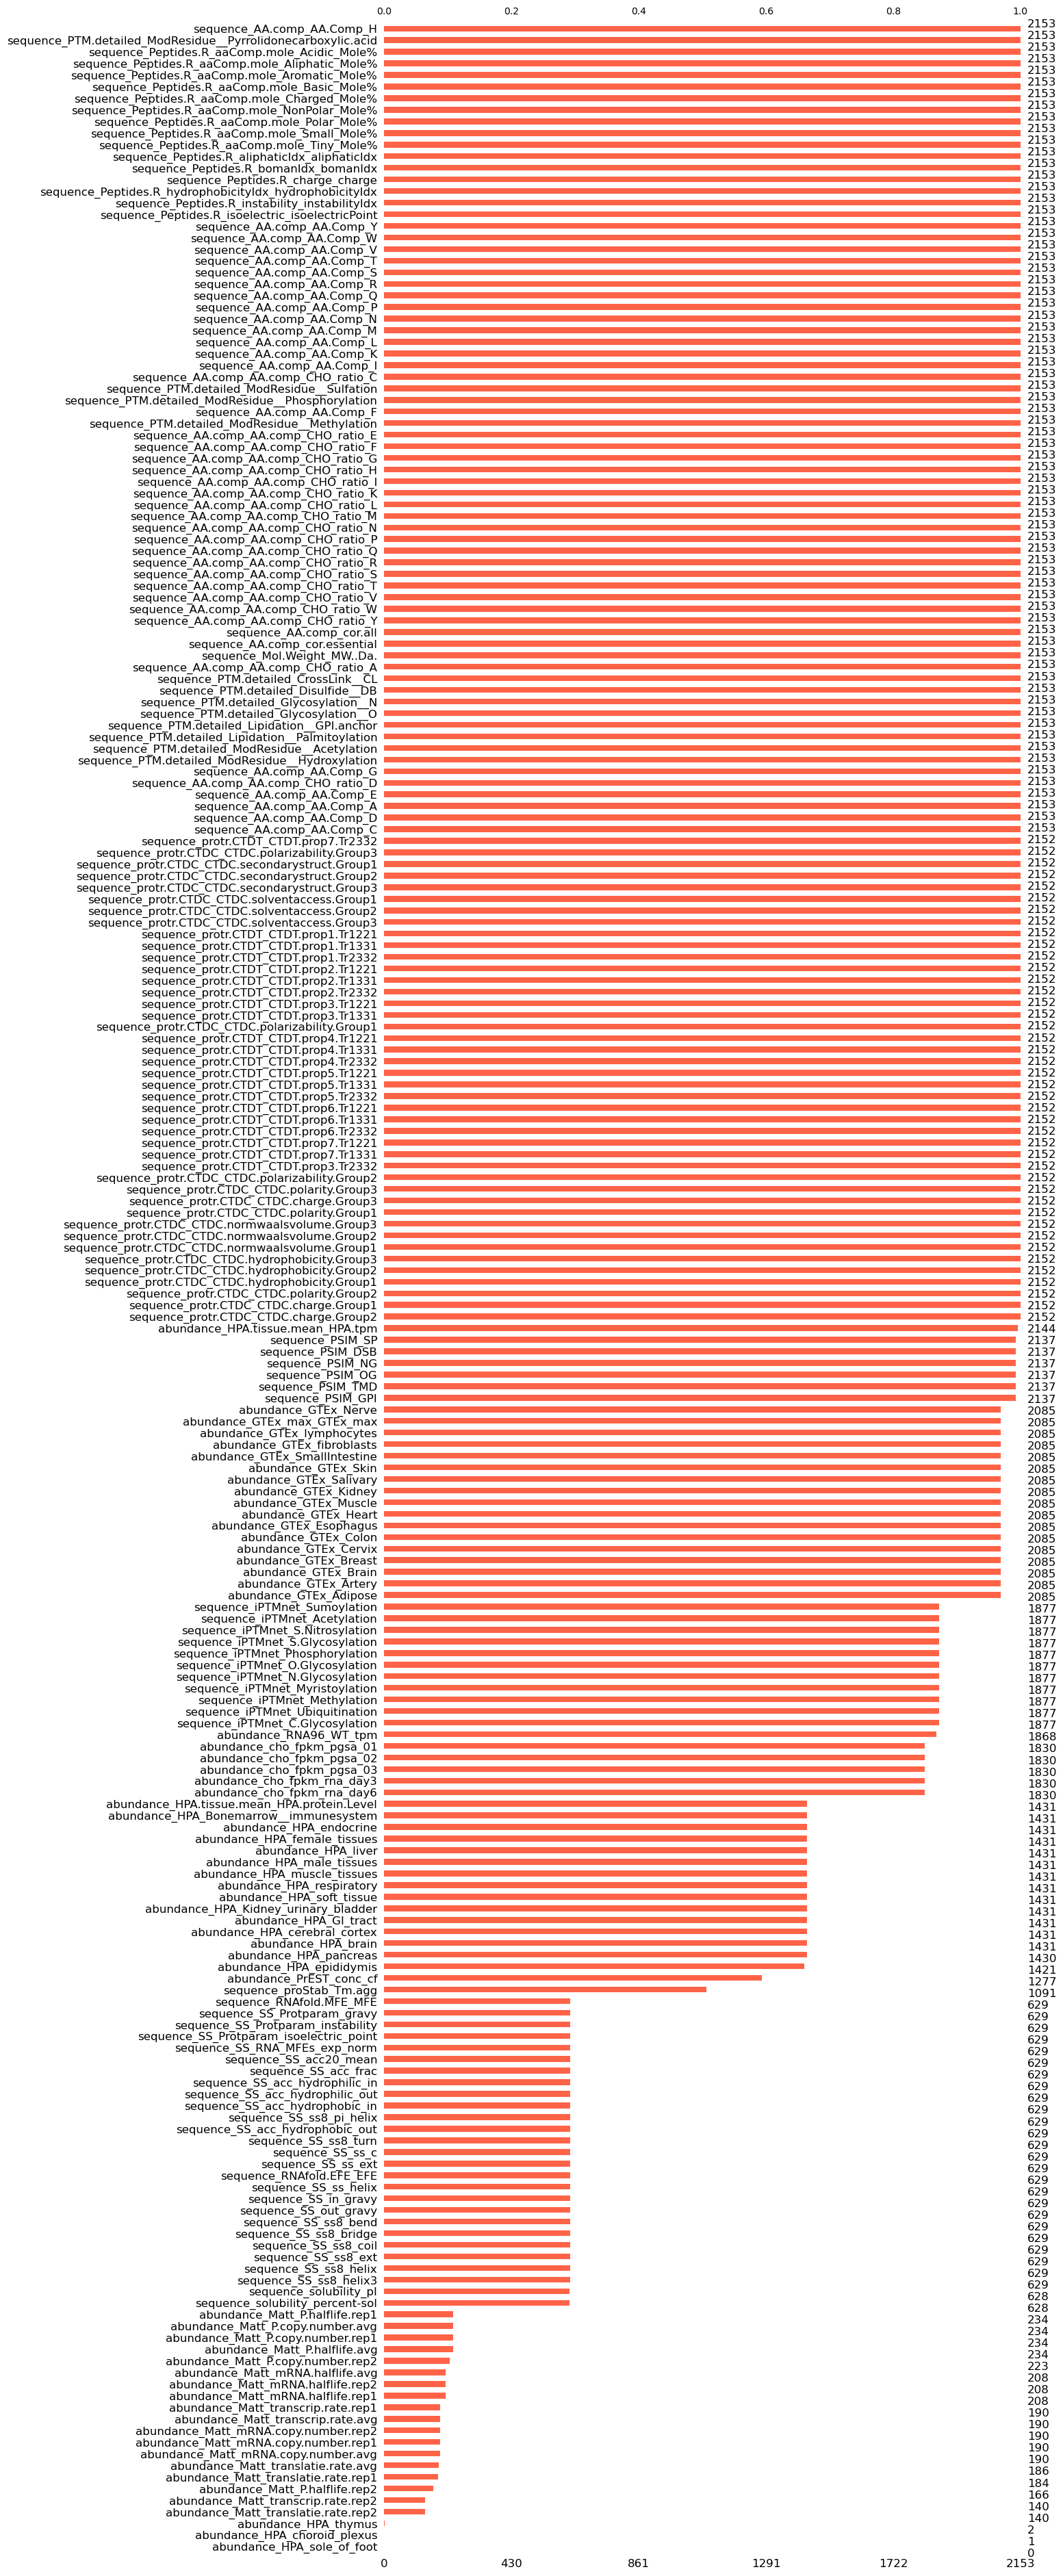

In [3]:
###########################
# Load & Preprocess Features
###########################

# Read the features file (same as before)
df = pd.read_excel('data/media-4.xlsx', sheet_name='all features')

# Drop columns that are not needed and set the index
df = df.drop(columns=['sample_ID','uniprot_id'])
df.set_index('human_symbol', inplace=True)

# Group by index (to average out duplicates, if any)
df = df.groupby(df.index).mean()

# Visualize missing values
msno.bar(df, figsize=(12, 48), sort="ascending", fontsize=12, color='tomato')

# Drop columns with more than 50% missing values
threshold = 0.5
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage > threshold].index
df_dropped = df.drop(columns=columns_to_drop)

# Impute remaining missing values using KNNImputer
original_index = df_dropped.index
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_dropped)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_dropped.columns, index=original_index)

In [4]:
###############################
# Load & Preprocess the Target
###############################

# Read the new target file for regression (Cell Growth Ratio)
target_df = pd.read_excel('data/secretome_samples_for_RNAseq_170111.xlsx', sheet_name='all')

# Select only the relevant columns
target_df = target_df[['Gene name', 'Cell conc (transfection)', 'Cell conc (harvest)']]

# Compute Cell Growth Ratio
target_df['Cell Growth Ratio'] = target_df['Cell conc (harvest)'] / target_df['Cell conc (transfection)']

# Remove the original columns after computing the ratio
target_df = target_df.drop(columns=['Cell conc (transfection)', 'Cell conc (harvest)'])

# Rename columns so that the gene names match the features dataframe index
target_df = target_df.rename(columns={'Gene name': 'human_symbol'})

# Set the index to 'human_symbol'
target_df.set_index('human_symbol', inplace=True)

# Drop any rows with missing values in the target variable
target_df = target_df.dropna(subset=['Cell Growth Ratio'])

In [5]:
######################################
# Merge Features with the Regression Target
######################################

# Join the imputed features with the target Cell Growth Ratio values
df_merged = df_imputed.join(target_df, how='inner')
print("Merged data shape:", df_merged.shape)

Merged data shape: (76, 171)


Zero-variability columns: Index(['sequence_PSIM_GPI', 'sequence_PTM.detailed_Lipidation__GPI.anchor',
       'sequence_iPTMnet_Myristoylation', 'sequence_iPTMnet_S.Glycosylation'],
      dtype='object')
81 columns to drop due to high correlation: ['abundance_GTEx_Breast', 'abundance_GTEx_Cervix', 'abundance_GTEx_Colon', 'abundance_GTEx_Esophagus', 'abundance_GTEx_Heart', 'abundance_GTEx_Kidney', 'abundance_GTEx_Muscle', 'abundance_GTEx_Nerve', 'abundance_GTEx_Salivary', 'abundance_GTEx_Skin', 'abundance_GTEx_SmallIntestine', 'abundance_GTEx_fibroblasts', 'abundance_GTEx_max_GTEx_max', 'abundance_HPA.tissue.mean_HPA.protein.Level', 'abundance_RNA96_WT_tpm', 'abundance_cho_fpkm_pgsa_01', 'abundance_cho_fpkm_pgsa_02', 'abundance_cho_fpkm_pgsa_03', 'abundance_cho_fpkm_rna_day3', 'abundance_cho_fpkm_rna_day6', 'sequence_AA.comp_AA.comp_CHO_ratio_A', 'sequence_AA.comp_AA.comp_CHO_ratio_C', 'sequence_AA.comp_AA.comp_CHO_ratio_D', 'sequence_AA.comp_AA.comp_CHO_ratio_E', 'sequence_AA.comp_AA.co

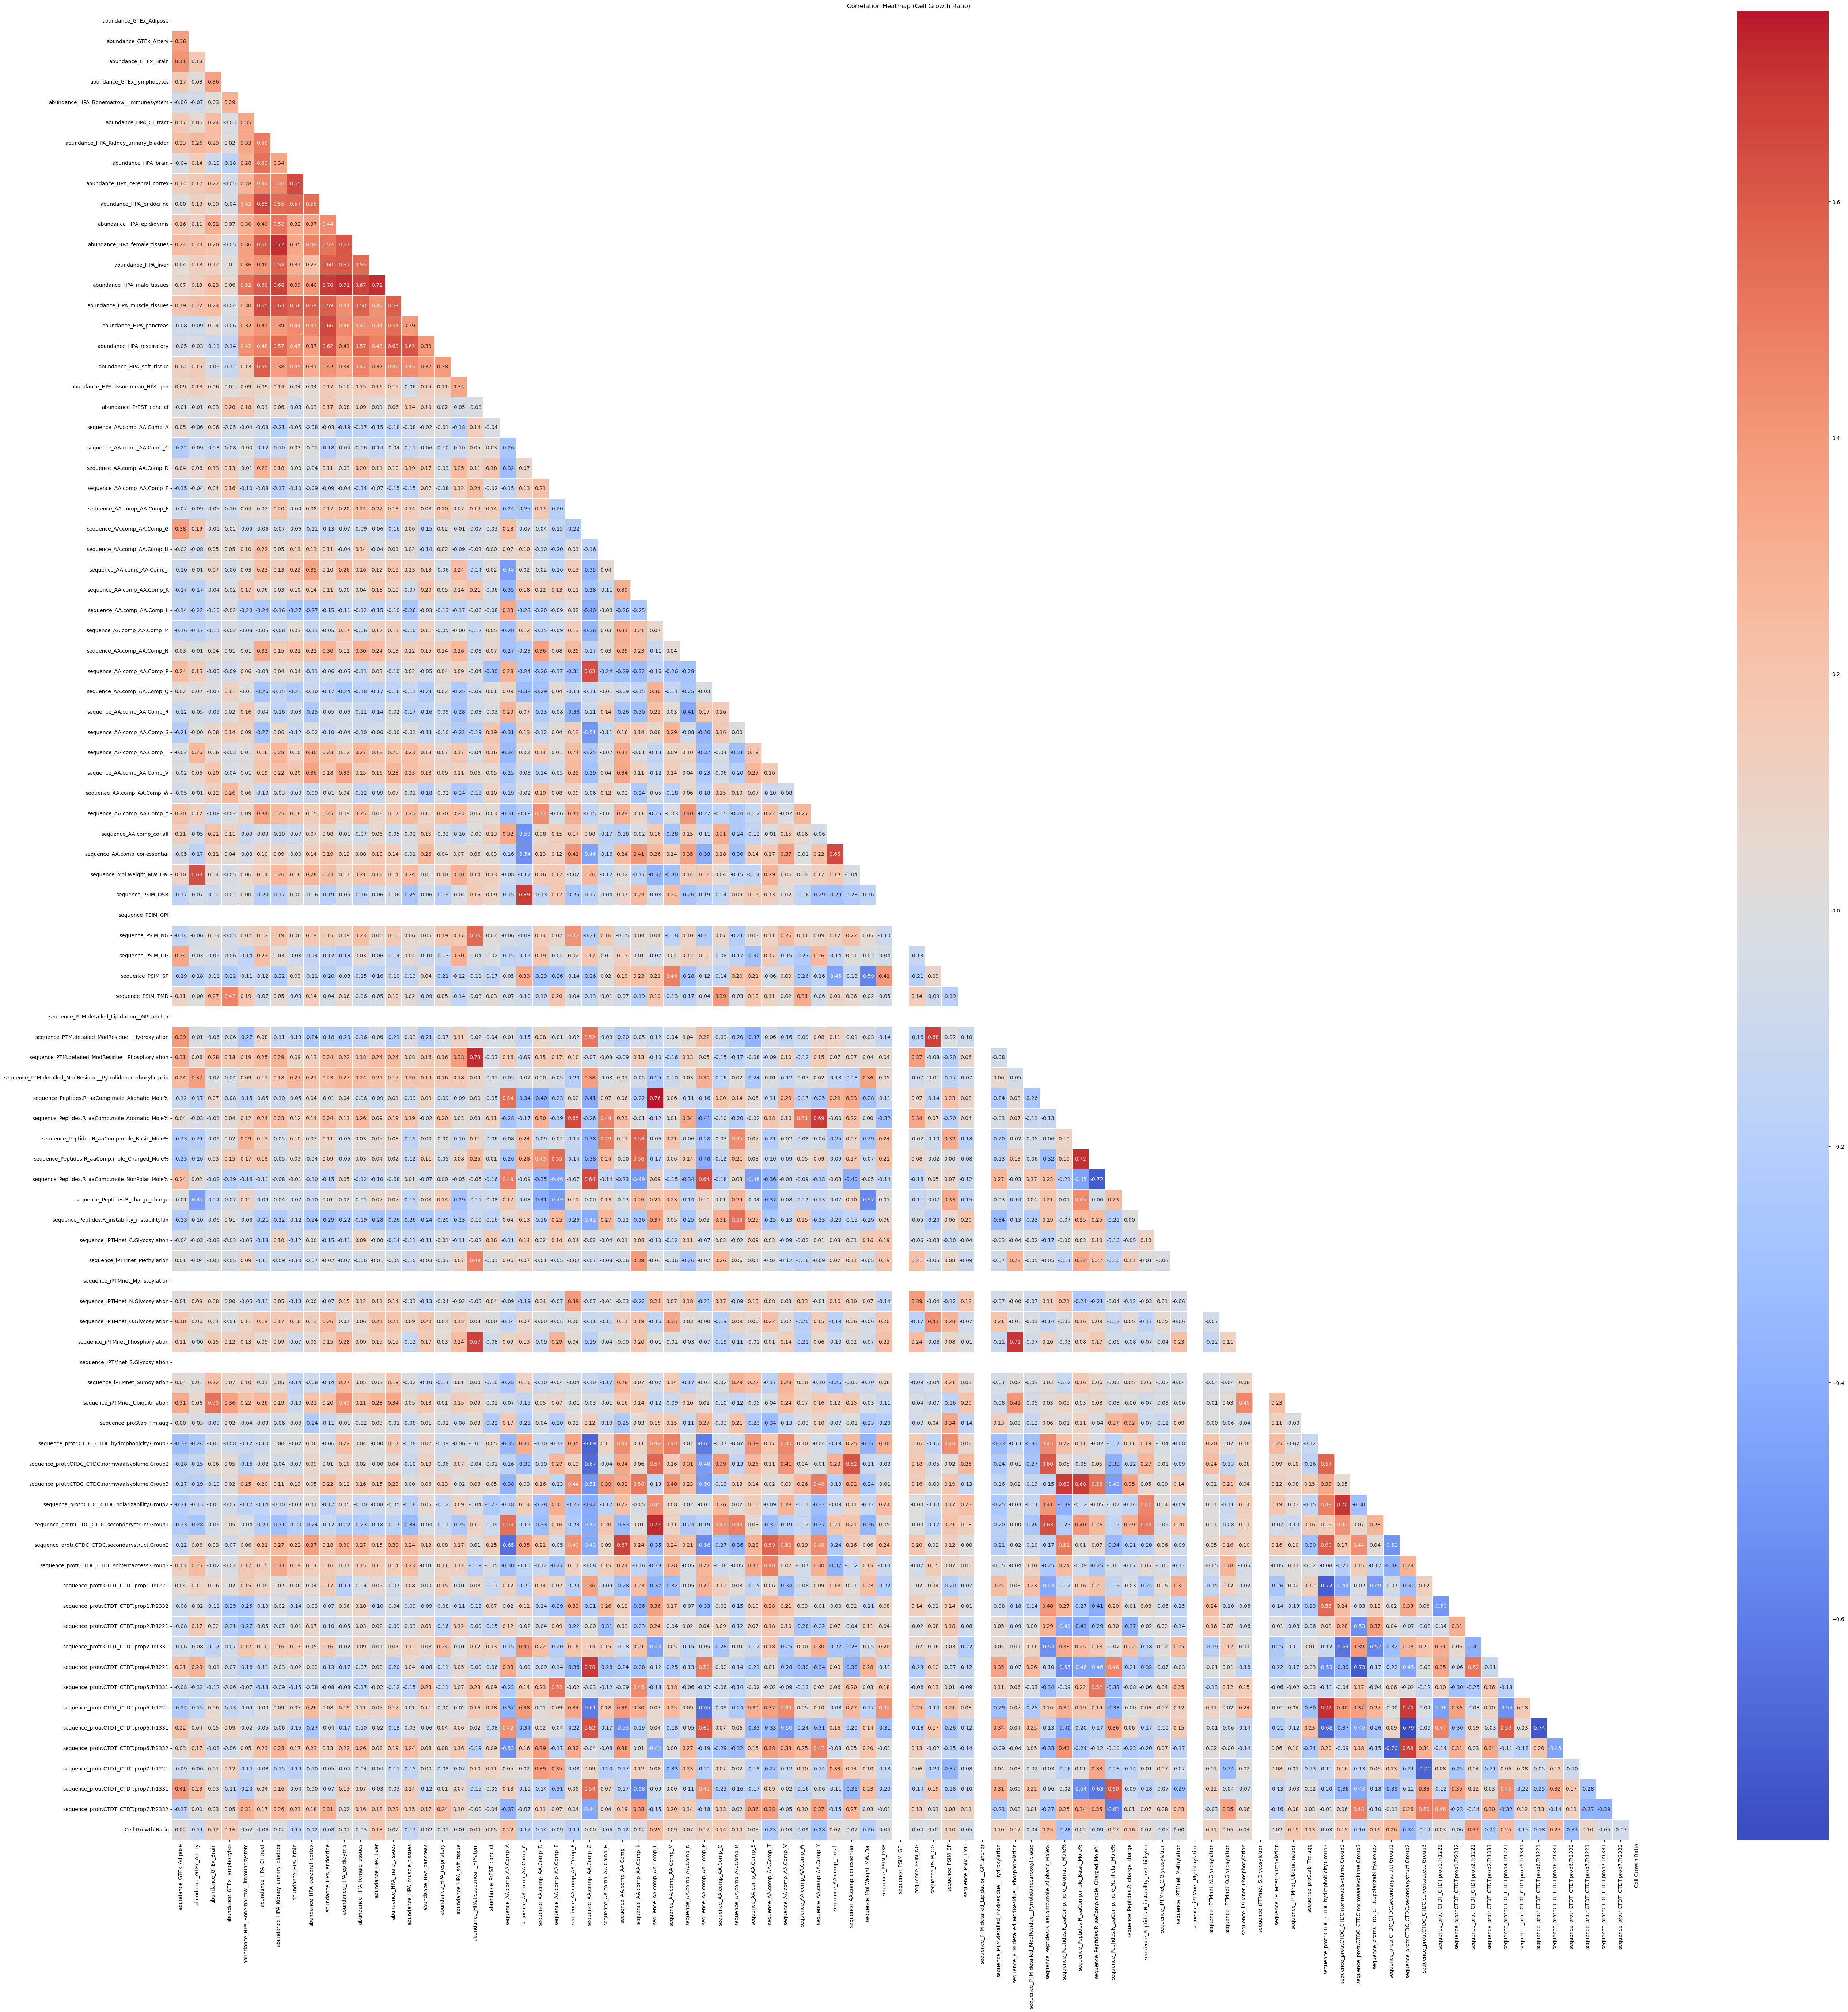

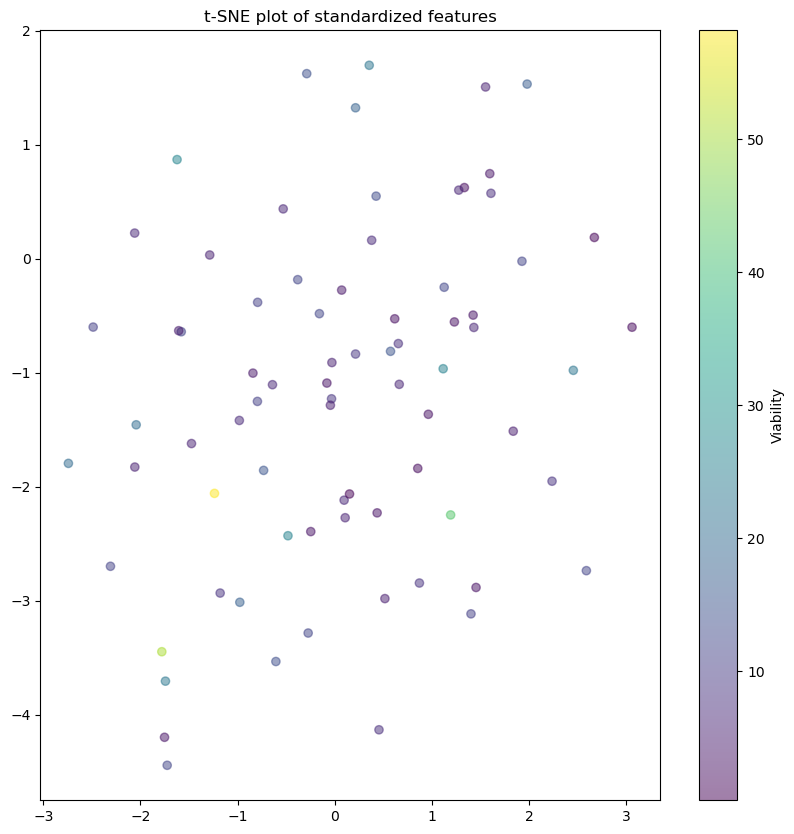

In [6]:
#############################################
# Explore Balance, Variability, and Correlations
#############################################

# Identify any columns with zero variability (if any)
zero_var_cols = df_merged.columns[df_merged.nunique() == 1]
print("Zero-variability columns:", zero_var_cols)

# Identify and drop highly correlated features (threshold = 0.80)
correlation_threshold = 0.80
correlation_matrix = df_merged.corr(method='pearson')
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > correlation_threshold)]
print(f'{len(to_drop)} columns to drop due to high correlation:', to_drop)

# Create a list of predictor columns by excluding the target and dropped columns
predictor_list = list(df_merged.columns)
predictor_list.remove('Cell Growth Ratio')
predictor_list = [x for x in predictor_list if x not in to_drop]
print("Number of predictors:", len(predictor_list))

# Visualize correlations (features vs. Cell Growth Ratio)
show_heatmap(df=df_merged, target='Cell Growth Ratio', predictor_list=predictor_list, 
             title='Correlation Heatmap (Cell Growth Ratio)', figsize=(65,65))

# (Optional) Standardize values and explore with t-SNE
X_stand  = standardize_values(df_merged[predictor_list].values)
t_sne_plot(X_stand, df_merged['Cell Growth Ratio'].values, title='t-SNE plot of standardized features')

#### Final Model Training and SHAP Analysis for Regression

In [11]:
feature_mapping = {
    # Amino-acid composition (AAC)
    "comp_AA.Comp_I":                      "AAC - Isoleucine",
    "AA.comp_AA.Comp_N":                   "AAC - Asparagine",
    "AA.comp_AA.Comp_A":                   "AAC - Alanine",
    "AA.comp_AA.Comp_L":                   "AAC - Leucine",
    "AA.comp_AA.Comp_V":                   "AAC - Valine",
    "AA.comp_AA.Comp_W":                   "AAC - Tryptophan",
    "comp_AA.Comp_T":                      "AAC - Threonine",
    "comp_AA.Comp_Y":                      "AAC - Tyrosine",
    "comp_AA.Comp_F":                      "AAC - Phenylalanine",
    "comp_AA.Comp_C":                      "AAC - Cysteine",
    "AA.comp_AA.Comp_H":                   "AAC - Histidine",
    "AA.comp_AA.Comp_R":                   "AAC - Arginine",
    "AA.comp_AA.Comp_P":                   "AAC - Proline",
    "AA.comp_AA.Comp_D":                   "AAC - Aspartic Acid",
    "AA.comp_AA.Comp_Q":                   "AAC - Glutamine",
    "Peptides.R_aaComp.mole_NonPolar_Mole%":"AAC - Non-Polar Residues (%)",
    "Peptides.R_aaComp.mole_Basic_Mole%":  "AAC - Basic Residues (%)",
    "Peptides.R_aaComp.mole_Aliphatic_Mole%":"AAC - Aliphatic Residues (%)",
    "R_aaComp.mole_Aromatic_Mole%":        "AAC - Aromatic Residues (%)",
    "Peptides.R_aaComp.mole_Charged_Mole%":"AAC - Charged Residues (%)",
    "AA.comp_cor.all":                     "AA Composition Correlation with Native CHO",
    "R_charge_charge":                     "Net Charge",

    # Global properties
    "Mol.Weight_MW..Da.":                  "Molecular Weight (Da)",
    "Weight_MW..Da.":                      "Molecular Weight (Da)",

    # CTDC (Composition) groups
    "CTDC_CTDC.secondarystruct.Group1":    "Secondary Structure: Helix (%)",
    "CTDC_CTDC.secondarystruct.Group2":    "Secondary Structure: Strand (%)",
    "CTDC_CTDC.normwaalsvolume.Group2":    "Medium Van der Waals Volume (%)",
    "CTDC_CTDC.normwaalsvolume.Group3":    "Large Van der Waals Volume (%)",
    "CTDC_CTDC.hydrophobicity.Group3":     "Hydrophobic Residues (%)",
    "CTDC_CTDC.polarizability.Group2":     "Medium Polarizability Residues (%)",

    # CTDT (Transition) descriptors
    "CTDT_CTDT.prop1.Tr1221":              "Transition Hydrophobicity: Hydrophobic/Neutral",
    "CTDT_CTDT.prop2.Tr1331":              "Transition Volume: Small/Large",
    "CTDT_CTDT.prop2.Tr1221":              "Transition Volume: Small/Medium",
    "CTDT_CTDT.prop4.Tr1221":              "Transition Polarizability: Low/Medium",
    "CTDT_CTDT.prop5.Tr1331":              "Transition Charge: Positive/Negative",
    "CTDT_CTDT.prop6.Tr1331":              "Transition Secondary Structure: Helix/Coil",
    "CTDT_CTDT.prop6.Tr1221":              "Transition Secondary Structure: Helix/Strand",
    "CTDT_CTDT.prop6.Tr2332":              "Transition Secondary Structure: Strand/Coil",
    "CTDT_CTDT.prop7.Tr1331":              "Transition Solvent Accessibility: Low/Medium",

    # Expression & PTM
    "abundance_GTEx_Artery":               "Gene Expression (Artery)",
    "abundance_HPA_pancreas":              "Protein Level (Pancreas)",
    "abundance_HPA_liver":                 "Protein Level (Liver)",
    "abundance_HPA_soft_tissue":           "Protein Level (Soft Tissue)",
    "abundance_HPA_male_tissues":          "Protein Level (Male Tissues)",
    "abundance_HPA_respiratory":           "Protein Level (Respiratory)",
    "abundance_HPA_endocrine":             "Protein Level (Endocrine)",
    "abundance_HPA_epididymis":            "Protein Level (Epididymis)",
    "abundance_PrEST_conc_cf":             "Production Yield in Yeast",
    "iPTMnet_Sumoylation":                 "Sumoylation",
    "iPTMnet_Ubiquitination":              "Ubiquitination",
    "PSIM_OG":                             "O-linked Glycosylation",
    "PSIM_DSB":                            "Disulfide Bond"
}

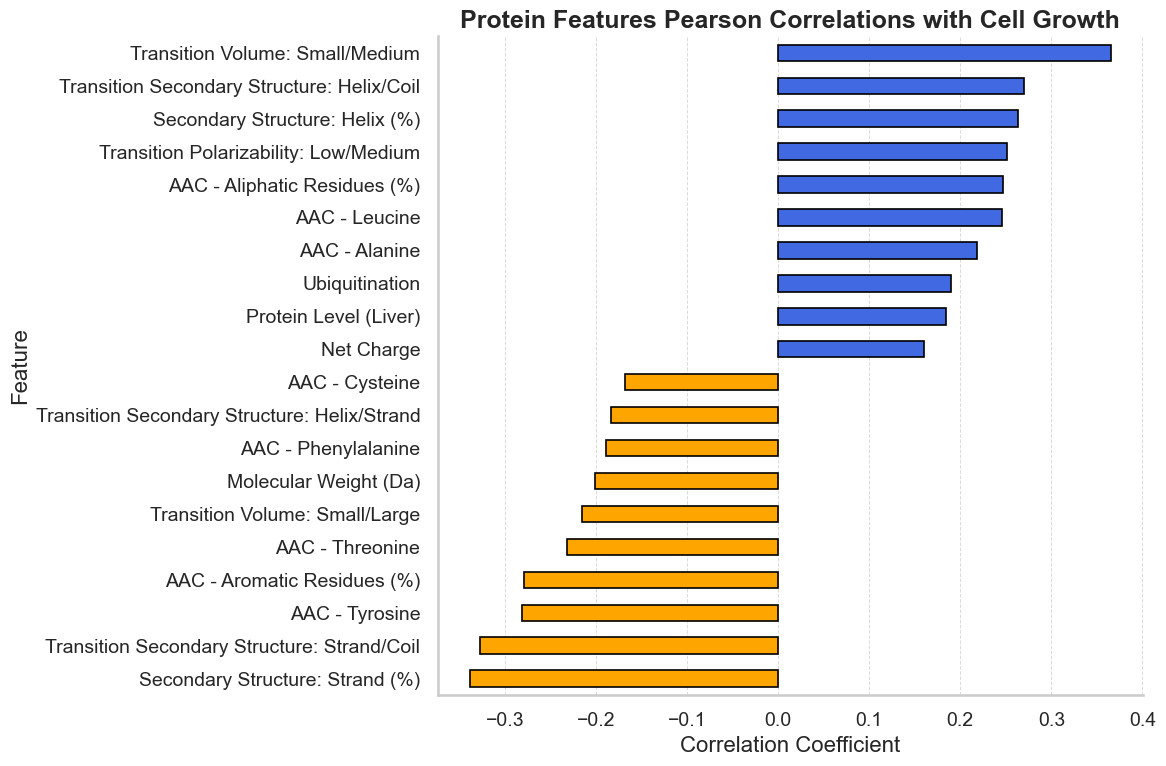

In [12]:
# Set a Seaborn theme for a clean and modern look.
sns.set_theme(style='whitegrid', context='talk')

# --- Step 1: Compute Pearson Correlations ---
# Calculate Pearson correlation coefficients between each feature and cell Cell Growth Ratio.
correlations = df_merged[predictor_list + ['Cell Growth Ratio']].corr()['Cell Growth Ratio'].drop('Cell Growth Ratio')
correlations = correlations.dropna()
correlations = correlations.sort_values()

# --- Step 2: Subset the Top 10 Negative and Top 10 Positive Correlations ---
top10_negative = correlations.head(10)
top10_positive = correlations.tail(10)

# Combine the two subsets into one Series and sort again.
subset_correlations = pd.concat([top10_negative, top10_positive]).sort_values()

# --- Step 3: Map Feature Names to Descriptive Labels ---

def map_feature_name(feature):
    # Remove the "sequence_" prefix if present.
    cleaned = feature.replace('sequence_', '')
    # Also remove a leading "protr." if present.
    if cleaned.startswith("protr."):
        cleaned = cleaned[len("protr."):]
    # Check if any mapping key is a substring of the cleaned feature name.
    for key, descriptive in feature_mapping.items():
        if key in cleaned:
            return descriptive
    # If no mapping is found, return the cleaned feature name.
    return cleaned

# The subset_correlations index contains the original feature names.
mapped_index = [map_feature_name(feat) for feat in subset_correlations.index]
subset_correlations.index = mapped_index

# --- Step 4: Define Colors and Update the Plot ---
# Define new colors: royalblue for positive correlations and orange for negative.
positive_color = 'royalblue'
negative_color = 'orange'
colors = [positive_color if val > 0 else negative_color for val in subset_correlations]

# --- Step 5: Plot the Correlation Analysis with Improved Aesthetics ---
plt.figure(figsize=(12, 8))
ax = subset_correlations.plot(kind='barh', color=colors, edgecolor='black', linewidth=1.2)
ax.set_title("Protein Features Pearson Correlations with Cell Growth", fontsize=18, weight='bold')
ax.set_xlabel("Correlation Coefficient", fontsize=16)
ax.set_ylabel("Feature", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.yaxis.grid(False)
sns.despine(ax=ax, top=True, right=True)

plt.savefig("results/corr_Cell Growth Ratio_protfeatures.svg", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [9]:
top10_positive

sequence_Peptides.R_charge_charge                  0.160627
abundance_HPA_liver                                0.184033
sequence_iPTMnet_Ubiquitination                    0.190167
sequence_AA.comp_AA.Comp_A                         0.218482
sequence_AA.comp_AA.Comp_L                         0.246255
sequence_Peptides.R_aaComp.mole_Aliphatic_Mole%    0.246965
sequence_protr.CTDT_CTDT.prop4.Tr1221              0.251665
sequence_protr.CTDC_CTDC.secondarystruct.Group1    0.263266
sequence_protr.CTDT_CTDT.prop6.Tr1331              0.269639
sequence_protr.CTDT_CTDT.prop2.Tr1221              0.365095
Name: Cell Growth Ratio, dtype: float64

In [10]:
top10_negative

sequence_protr.CTDC_CTDC.secondarystruct.Group2   -0.338626
sequence_protr.CTDT_CTDT.prop6.Tr2332             -0.327790
sequence_AA.comp_AA.Comp_Y                        -0.280696
sequence_Peptides.R_aaComp.mole_Aromatic_Mole%    -0.278493
sequence_AA.comp_AA.Comp_T                        -0.231998
sequence_protr.CTDT_CTDT.prop2.Tr1331             -0.215484
sequence_Mol.Weight_MW..Da.                       -0.200916
sequence_AA.comp_AA.Comp_F                        -0.188705
sequence_protr.CTDT_CTDT.prop6.Tr1221             -0.182995
sequence_AA.comp_AA.Comp_C                        -0.167632
Name: Cell Growth Ratio, dtype: float64